In [1]:
%matplotlib inline

In [2]:
# python libraries
import menpo
import tensorflow as tf
import menpo.io as mio
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path

from tensorflow.python.platform import tf_logging as logging
from menpo.image import Image
from menpo.shape import PointCloud

# local libraries
import utils, networks, data_provider


np.set_printoptions(3)
slim = tf.contrib.slim

### Convolutional Support Vector Shape

In [3]:
nogpu_config = tf.ConfigProto(
    # Do not use a GPU device
    device_count = {'GPU': 0}
)

sess = tf.InteractiveSession(config=nogpu_config)

### restore network

In [4]:
model_path = 'saved/model.ckpt-1972331'
images_input = tf.placeholder(tf.float32, shape=(None, None, None, 3), name='input_images')

In [5]:
layers = []
net_model = networks.DNSVSHG()
net_model.network_path = 'saved/weight.pkl'
with tf.variable_scope('net'):
    with slim.arg_scope([slim.batch_norm, slim.layers.dropout], is_training=False):
        lms_heatmap_prediction, states = net_model._build_network(images_input, layers)


In [6]:
variables_to_restore = slim.get_variables_to_restore()
saver = tf.train.Saver(variables_to_restore)

saver.restore(sess, model_path)

### load record

In [9]:
filename = 'saved/train.tfrecords'
provider = data_provider.ProtobuffProvider('train.tfrecords','saved/')
data = []
for j,serialized_example in enumerate(tf.python_io.tf_record_iterator(filename)):
    features = provider._get_features(serialized_example)
    
    # image
    image, image_height, image_width = provider._image_from_feature(features)

    # svs
    pose, n_svs, n_svs_ch = provider._pose_from_feature(features)

    # landmarks
    gt_heatmap, gt_lms, n_landmarks, visible, marked = provider._heatmap_from_feature(features)

    # infomations
    scale = provider._info_from_feature(features)
    
    # crop to 256 * 256
    target_h = tf.to_int32(256)
    target_w = tf.to_int32(256)
    offset_h = tf.to_int32((image_height - target_h) / 2)
    offset_w = tf.to_int32((image_width - target_w) / 2)

    image = tf.image.crop_to_bounding_box(
        image, offset_h, offset_w, target_h, target_w)

    pose = tf.image.crop_to_bounding_box(
        pose, offset_h, offset_w, target_h, target_w)
    pose = tf.reshape(pose, (target_h,target_w,n_svs,n_svs_ch))
    pose = tf.transpose(pose, perm=[2, 0, 1, 3])

    gt_heatmap = tf.image.crop_to_bounding_box(
        gt_heatmap, offset_h, offset_w, target_h, target_w)

    gt_lms -= tf.to_float(tf.pack([offset_h, offset_w]))
#     break
    data.append((image, pose))
    
    if j > 2:
        break

### landmark localisation

In [10]:
image, pose = data[0]

In [11]:
input_pixels = sess.run(image) / 255

In [12]:
lms_hm_prediction, *states_prediction = sess.run(
    [lms_heatmap_prediction] + states, 
    feed_dict={images_input: input_pixels[None, ...]})

### visualisation

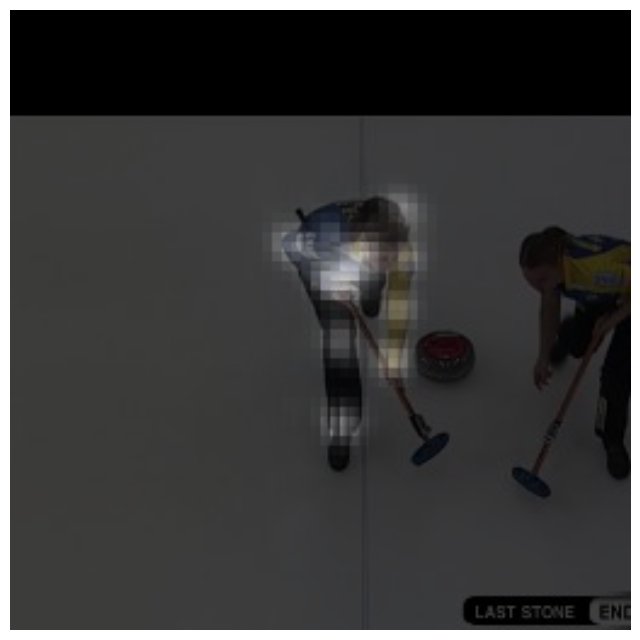

In [13]:
Image.init_from_channels_at_back(input_pixels).view()
Image.init_from_channels_at_back(np.mean(lms_hm_prediction[0],axis=-1)).view(alpha=0.75)